In [ ]:
import math as m
import numpy as np
import scipy as sp

from obspy.core import UTCDateTime, read, Stream, Trace

import matplotlib.pyplot as plt
%matplotlib ipympl

Now, we want to estimate the interstory drift with 6C data. 6C data allowss us to corect for missorientation and dynamic tilt.

In [ ]:
#  We need to define the secant function
def sec(x):
    return 1/m.cos(x)


This is the function that applies the attitude correction (after Lin et al. 2010, BSSA, 
https://doi.org/10.1785/0120090123)<br>
Application of Eqn 10, Eqn 15 and Eqn 4:

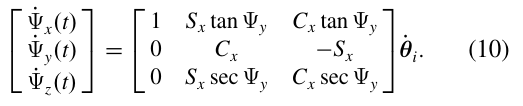 <br>

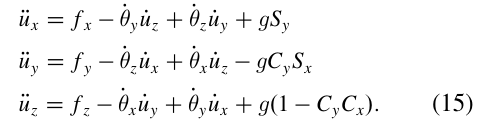 <br>

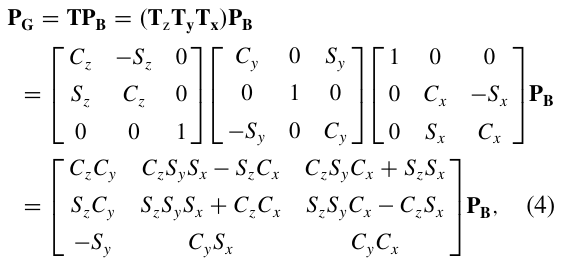



In [ ]:
def Attitude(TAxB, TAyB, TAzB, RVxB, RVyB, RVzB, sps, one_g, fmin, fmax):
####################################################################################################
    
    NN = len(RVxB)				# Length of ORIGINAL data vectors
    dt = 1./sps
  
    if NN != len(RVyB) or NN != len(RVzB) or NN != len(TAxB) or NN != len(TAyB) or NN != len(TAzB):
        print('error: Input vectors must be of equal length!')

    EAx0G = 0
    EAy0G = 0
    EAz0G = 0
     
    ##################################################
    # Pad inputs with a leading zero (length NN+1;
    # thus, ignore first output value) and create
    # output vectors
    
    pTAxB = np.zeros(NN+1)
    pTAxB[1:] = TAxB                    # Input acceleration in {B} ("p" means padded)
    pTAyB = np.zeros(NN+1)
    pTAyB[1:] = TAyB                    # Input acceleration in {B} ("p" means padded)
    pTAzB = np.zeros(NN+1)
    pTAzB[1:] = TAzB                    # Input acceleration in {B} ("p" means padded)
    
    pRVxB = np.zeros(NN+1)
    pRVxB[1:] = RVxB                    # Input rotation rate in {B} ("p" means padded)
    pRVyB = np.zeros(NN+1)
    pRVyB[1:] = RVyB                    # Input rotation rate in {B} ("p" means padded)
    pRVzB = np.zeros(NN+1)
    pRVzB[1:] = RVzB                    # Input rotation rate in {B} ("p" means padded)
    
    pEAxG = np.ones(NN+1)
    pEAxG[0] = EAx0G	# Initialize Euler angles (output; padded)
    pEAyG = np.ones(NN+1)
    pEAyG[0] = EAy0G
    pEAzG = np.ones(NN+1)
    pEAzG[0] = EAz0G
    
    pTVxB = np.zeros(NN+1)	# Starts motionless in {B} (padded)
    pTVyB = np.zeros(NN+1)
    pTVzB = np.zeros(NN+1)
    
    pTVxG = np.ones(NN+1)	# Output velocity in {G} (output; padded)
    pTVyG = np.ones(NN+1)
    pTVzG = np.ones(NN+1)
    
    
    ##################################################
    # Loop over time
    
    for ii in range(NN):
    
        ##########################################
        # Values used below repeatedly and buffered inputs,
        # all for time step (ii) and used to generate
        # outputs at both time steps (ii) and (ii+1)
    
        SinXg  = np.sin(pEAxG[ii])		# Used repeatedly below
        CosXg  = np.cos(pEAxG[ii])
    
        SinYg  = np.sin(pEAyG[ii])		# Ditto ...
        CosYg  = np.cos(pEAyG[ii])
        TanYg  = np.tan(pEAyG[ii])
        SecYg  = sec(pEAyG[ii])
    
        SinZg  = np.sin(pEAzG[ii])		# Ditto ...
        CosZg  = np.cos(pEAzG[ii])
    
        TpRVx  = pRVxB[ii]			# Buffers to avoid overwriting inputs
        TpRVy  = pRVyB[ii]			#    during computations; also faster
        TpRVz  = pRVzB[ii]			#    recall ("T" means temporary)
    
        TpTVxB = pTVxB[ii]			# Ditto ...
        TpTVyB = pTVyB[ii]
        TpTVzB = pTVzB[ii]
    
        TpEAx  = pEAxG[ii]			# Ditto ...
        TpEAy  = pEAyG[ii]
        TpEAz  = pEAzG[ii]
    
    
        ##########################################
        # Step (1)-- Eqn (10) from Lin et al. 20210: ATTITUDE EQUATION; find the
        # orientation of {B} within {G} (output for time
        # step (ii+1))
    
        pEAxG[ii+1] = pEAxG[ii] + (dt * ( TpRVx + (SinXg * TanYg * TpRVy) + (CosXg * TanYg * TpRVz) ))
    
        pEAyG[ii+1] = pEAyG[ii] + (dt * ((CosXg * TpRVy) - (SinXg * TpRVz) ))
    
        pEAzG[ii+1] = pEAzG[ii] + (dt * ((SinXg * SecYg * TpRVy) + (CosXg * SecYg * TpRVz) ))

        ########################################## 
        # Step (2)-- Eqn (15) from Lin et al. 20210: ATTITUDE-CORRECTION EQUATION -- to
        # correct the input velocities for tilt (gravity) 
        pTVxB[ii+1] = TpTVxB + (dt * ( pTAxB[ii] + (one_g * SinYg) ))
    
        pTVyB[ii+1] = TpTVyB + (dt * ( pTAyB[ii] - (one_g * CosYg * SinXg) ))
    
        pTVzB[ii+1] = TpTVzB + (dt * ( pTAzB[ii] + (one_g * (1 - CosYg * CosXg)) ))
        ########################################## 
        # Step (3)-- Eqn (4) from Lin et al. 20210: TRANSFORM {B} velocities to
        # {G} velocities (NOTE:  output for time step (ii))
    
        pTVxG[ii] = TpTVxB * (CosZg * CosYg) + TpTVyB * (CosZg * SinYg * SinXg - SinZg * CosXg) + TpTVzB * (CosZg * SinYg * CosXg + SinZg * SinXg)
    
        pTVyG[ii] = TpTVxB * (SinZg * CosYg) + TpTVyB * (SinZg * SinYg * SinXg + CosZg * CosXg) + TpTVzB * (SinZg * SinYg * CosXg - CosZg * SinXg)
    
        pTVzG[ii] = TpTVxB * (-SinYg       ) + TpTVyB * (CosYg * SinXg                        ) + TpTVzB * (CosYg * CosXg                        )

    #########################
    # Since steps (1) and (2) are creating values for
    # time step (ii+1) from values at time step (ii) BUT
    # step (3) is only creating values at time step (ii),
    # so the value of pTV[xyz]B(ii+1) is computed here:
    
    TpTVxB = pTVxB[NN]
    TpTVyB = pTVyB[NN]
    TpTVzB = pTVzB[NN]
    
    SinXg  = np.sin(pEAxG[NN])
    CosXg  = np.cos(pEAxG[NN])
    
    SinYg  = np.sin(pEAyG[NN])
    CosYg  = np.cos(pEAyG[NN])
    
    SinZg  = np.sin(pEAzG[NN])
    CosZg  = np.cos(pEAzG[NN])
    
    pTVxG[NN] = TpTVxB * (CosZg * CosYg) + TpTVyB * (CosZg * SinYg * SinXg - SinZg * CosXg) + TpTVzB * (CosZg * SinYg * CosXg + SinZg * SinXg)
    
    pTVyG[NN] = TpTVxB * (SinZg * CosYg) + TpTVyB * (SinZg * SinYg * SinXg + CosZg * CosXg) + TpTVzB * (SinZg * SinYg * CosXg - CosZg * SinXg)
    
    pTVzG[NN] = TpTVxB * (-SinYg       ) + TpTVyB * (CosYg * SinXg                        ) + TpTVzB * (CosYg * CosXg                        )
    
    
    #########################
    # Reasonably selected records should have zero initial
    # translational velocity, so force this result
    
    tr_pTVxG = Trace(data=pTVxG)
    tr_pTVxG.stats.sampling_rate = sps
    st_ptVxG = Stream(traces=tr_pTVxG)

    tr_pTVyG = Trace(data=pTVyG)
    tr_pTVyG.stats.sampling_rate = sps
    st_ptVyG = Stream(traces=tr_pTVyG)

    tr_pTVzG = Trace(data=pTVzG)
    tr_pTVzG.stats.sampling_rate = sps
    st_ptVzG = Stream(traces=tr_pTVzG)

    
    ##################################################
    # Step (4a), integrate {G} velocities to {G} to
    # displacements (does trivial demean by first sample
    
    
    ##################################################
    # Step (4b), differentiate {G} velocities to {G} accelerations (leading
    # and ending samples of the velocity, pTV[xyz]G, are lost in Deriv3(), so
    # replicate end velocity value on input (the leading velocity input sample
    # being a pad already) and replaces beginning zero on output, the latter
    # just for consistency with other front-padded output arrays)
    
    for tr in st_ptVxG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAxG = st_ptVxG.copy()
    st_ptDxG = st_ptVxG.copy()
    st_ptAxG.differentiate()
    st_ptDxG.integrate()
    for tr in st_ptDxG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean

    for tr in st_ptVyG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAyG = st_ptVyG.copy()
    st_ptDyG = st_ptVyG.copy()
    st_ptAyG.differentiate()
    st_ptDyG.integrate()
    for tr in st_ptDyG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    
    for tr in st_ptVzG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAzG = st_ptVzG.copy()
    st_ptDzG = st_ptVzG.copy()
    st_ptAzG.differentiate()
    st_ptDzG.integrate()
    for tr in st_ptDzG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean

    #st_ptDzG.taper(0.01)
    st_ptDzG.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
    #st_ptDyG.taper(0.01)
    st_ptDyG.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
    #st_ptDyG.taper(0.01)
    st_ptDxG.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
    
    pTAxG = st_ptAxG[0].data
    pTAyG = st_ptAyG[0].data
    pTAzG = st_ptAzG[0].data

    pTVxG = st_ptVxG[0].data
    pTVyG = st_ptVyG[0].data
    pTVzG = st_ptVzG[0].data
    
    pTDxG = st_ptDxG[0].data
    pTDyG = st_ptDyG[0].data
    pTDzG = st_ptDzG[0].data
    
    ##################################################
    # Remove the leading zero pad (the trailing pad
    # for accelerations fell away in Deriv3())
    
    TAxG = pTAxG[1:NN]
    TAyG = pTAyG[1:NN]
    TAzG = pTAzG[1:NN]
    
    TVxG = pTVxG[1:NN]
    TVyG = pTVyG[1:NN]
    TVzG = pTVzG[1:NN]
    
    TDxG = pTDxG[1:NN]
    TDyG = pTDyG[1:NN]
    TDzG = pTDzG[1:NN]
    
    EAxG = pEAxG[1:NN]
    EAyG = pEAyG[1:NN]
    EAzG = pEAzG[1:NN] 

    return (TAxG, TAyG, TAzG, TVxG, TVyG, TVzG, TDxG, TDyG, TDzG, EAxG, EAyG, EAzG)


####################################################################################################



We performed a shake table experiment with a steel structure on top of a 1D-shaker. The steel structure was equipped with 14 6C sensors, 3 low cost accelerometers and 3 displacement sensors.

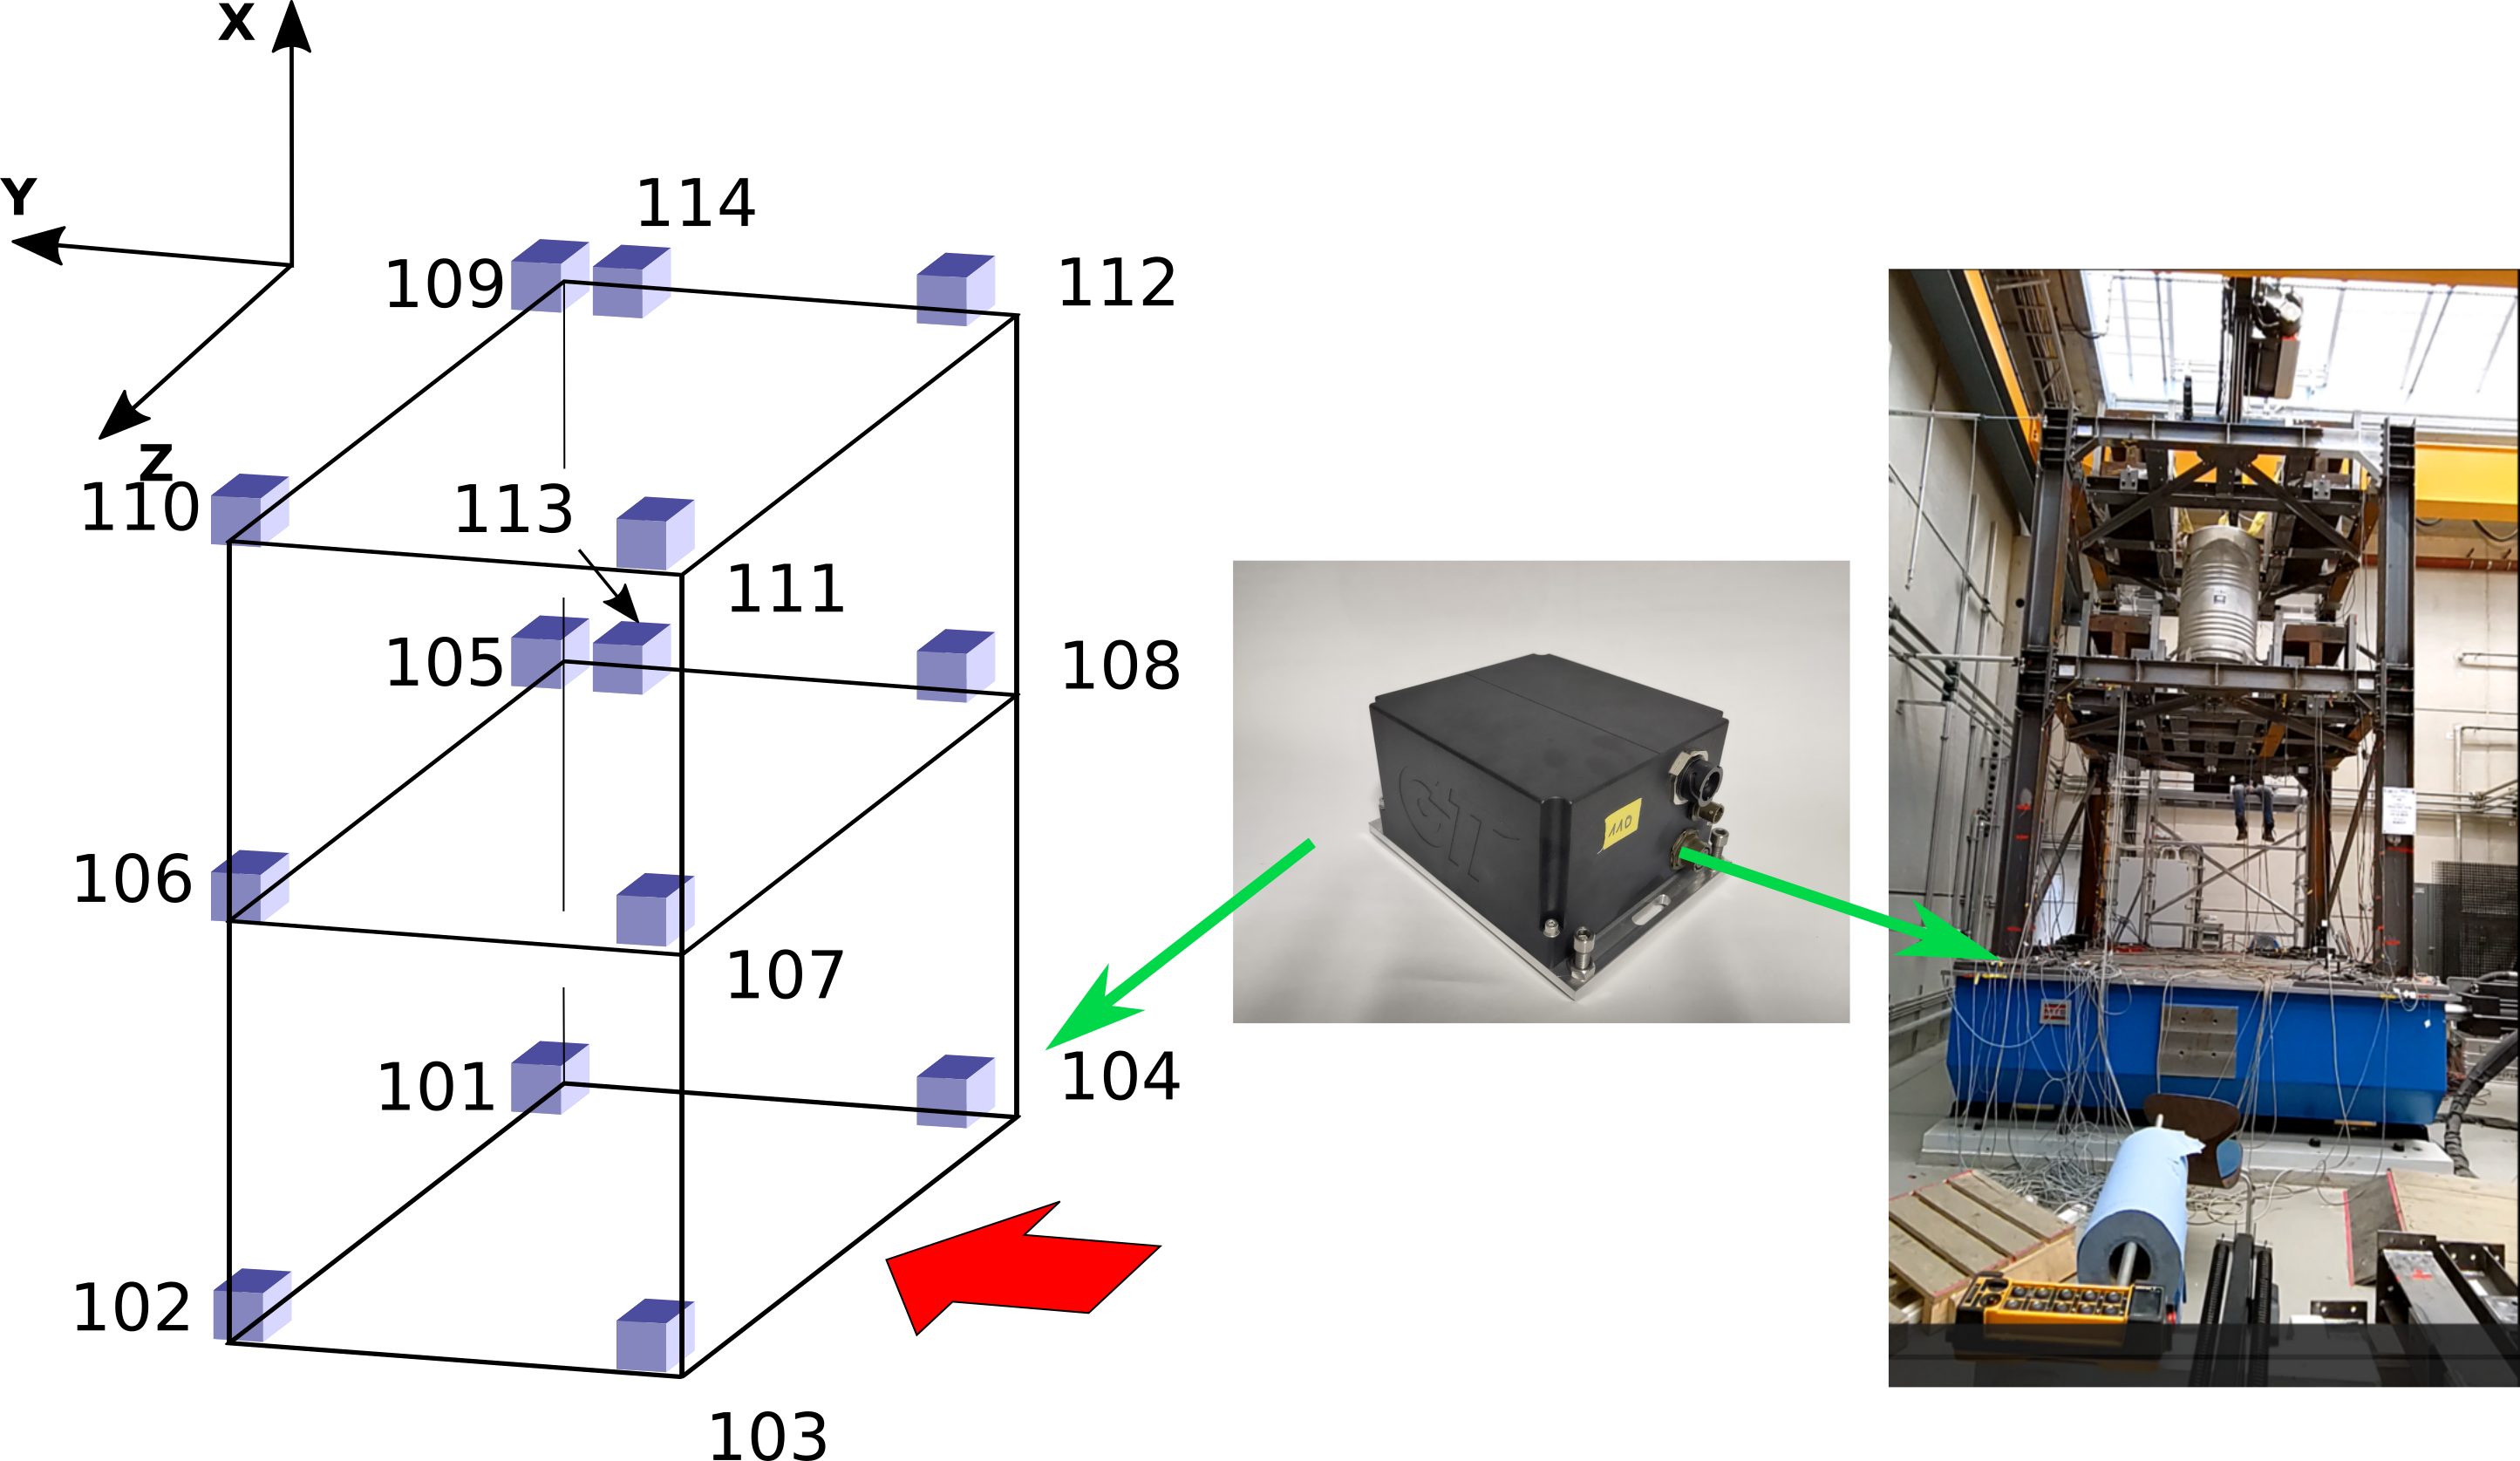


To understand the data we need to clarify positions and orientations of the stations and channels: 

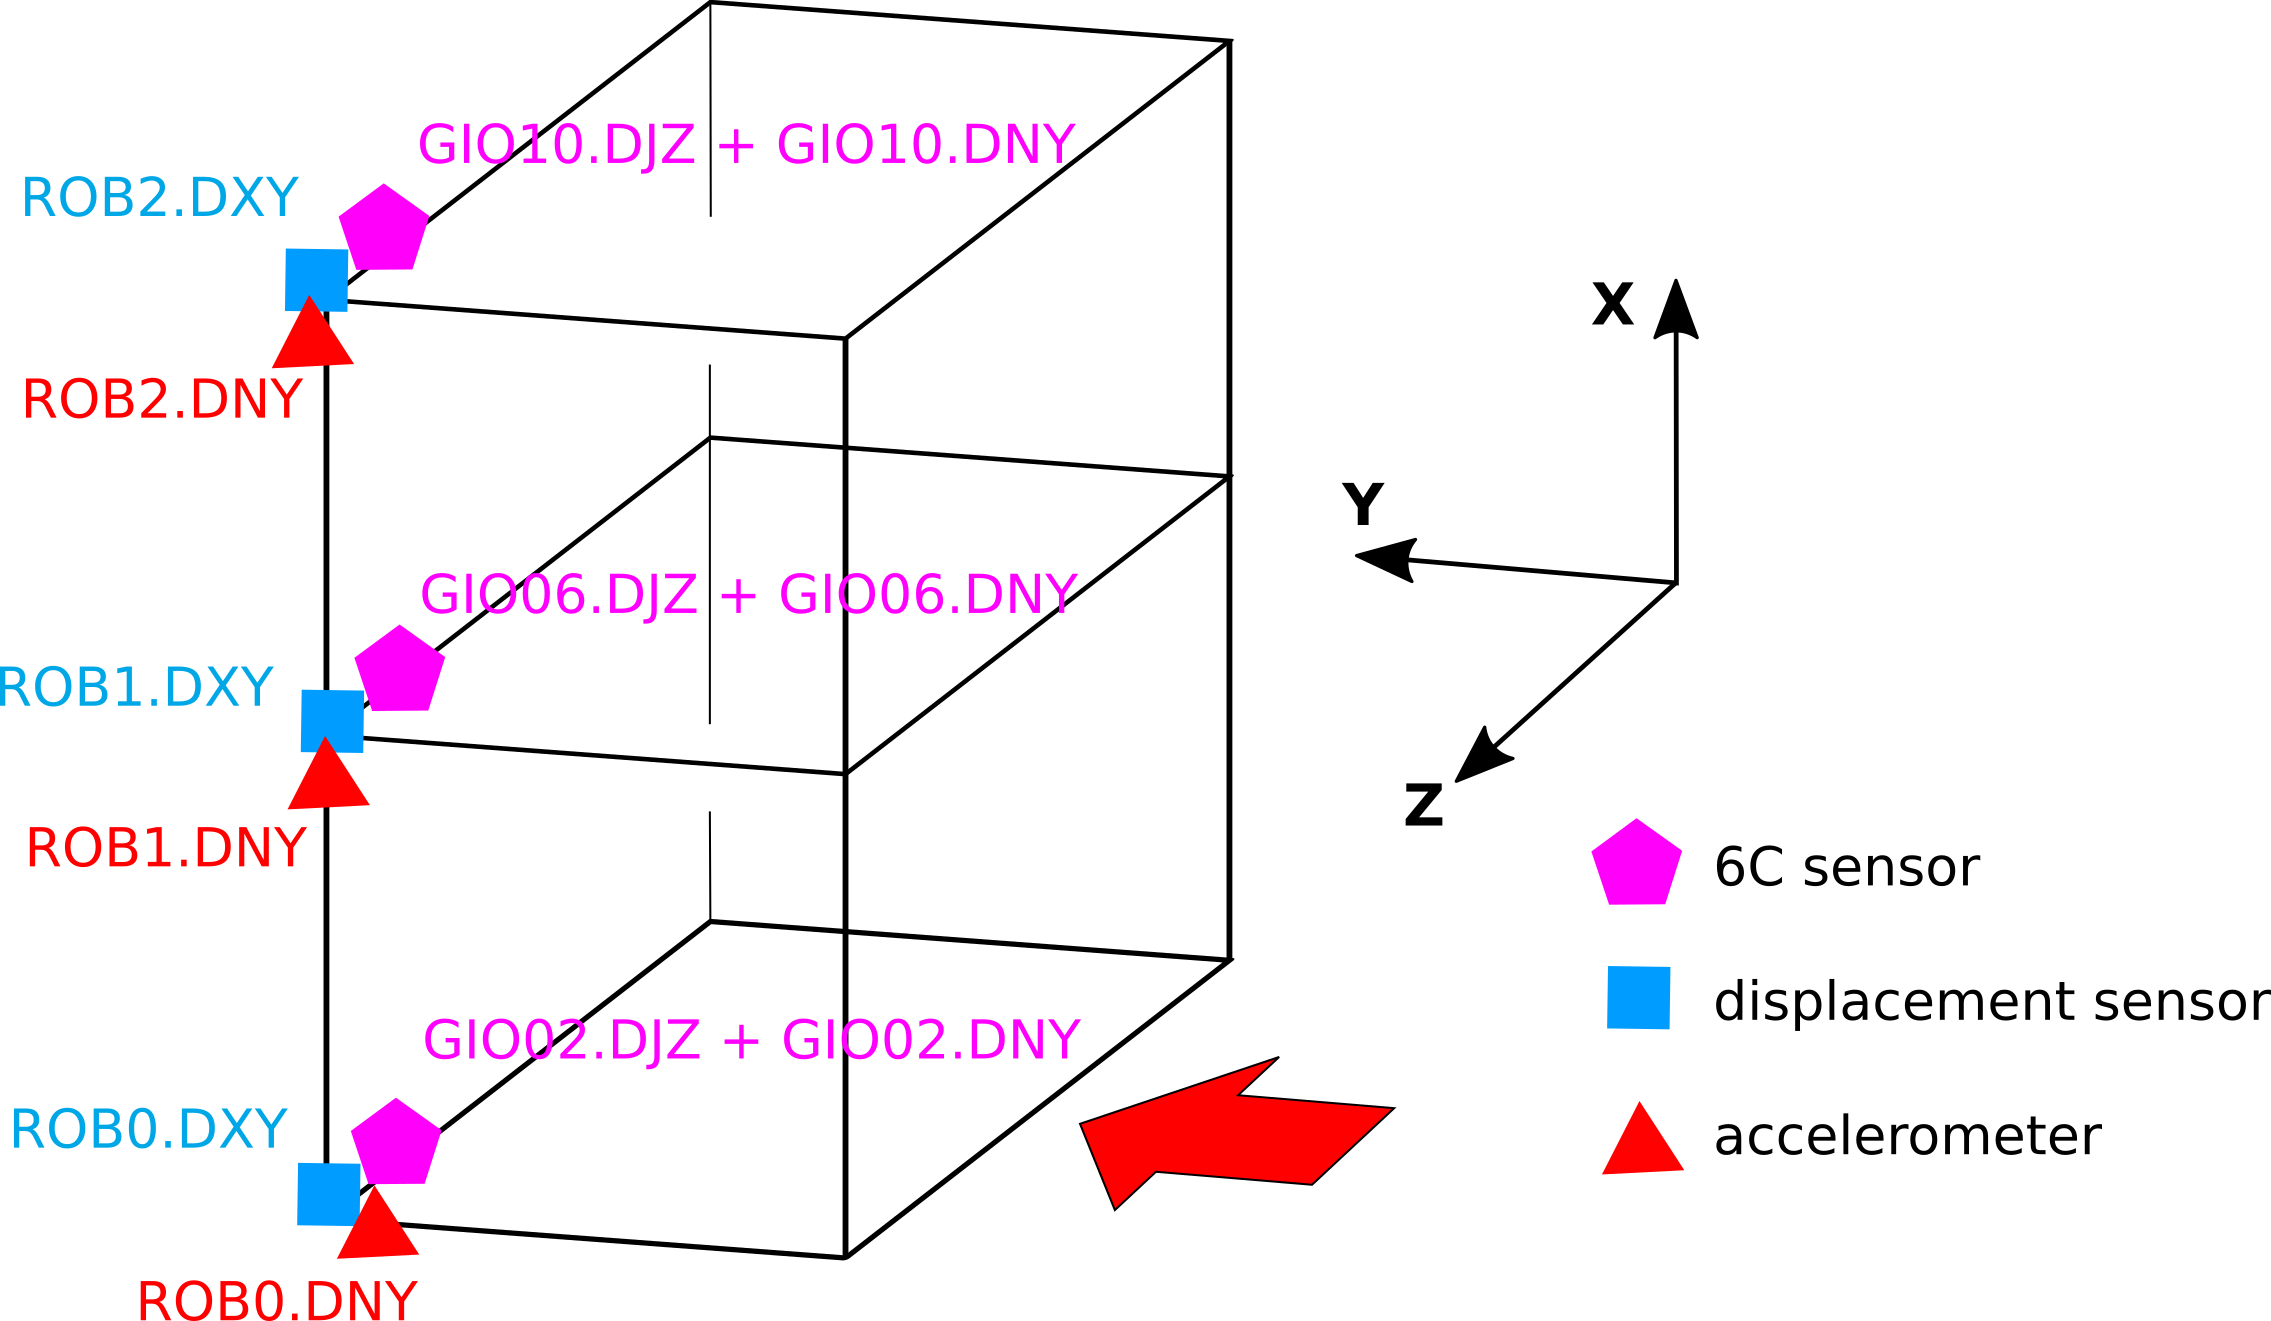


Get the data and pre-process it (remove response, rotate, filter, resample)

In [ ]:
PATH = 'mseed/'

net = 'XX'
loc= ''

# you can choose the station here:
sta_DISP0 = 'ROB0'
sta_DISP1 = 'ROB1'
sta_DISP2 = 'ROB2'

# we have only one-component data from the displacement sensors and from the accelerometers
cha_disp = 'DXY'
cha_acc = 'DNY'

sta_6C0 = 'GIO02'
sta_6C1 = 'GIO06'
sta_6C2 = 'GIO10'

# we take all 6 channels from the 6C data
cha_6C = 'D*'

utctime = UTCDateTime('2023-06-23T07:29:44') #0.9g

YYYY = str(utctime.year)
DOY = str(utctime.julday).zfill(3)

dt = 80

st_DISP0 = read(PATH+net+'.'+sta_DISP0+'.'+loc+'.'+cha_disp+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_DISP1 = read(PATH+net+'.'+sta_DISP1+'.'+loc+'.'+cha_disp+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_DISP2 = read(PATH+net+'.'+sta_DISP2+'.'+loc+'.'+cha_disp+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)

st_ACC0 = read(PATH+net+'.'+sta_DISP0+'.'+loc+'.'+cha_acc+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_ACC1 = read(PATH+net+'.'+sta_DISP1+'.'+loc+'.'+cha_acc+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_ACC2 = read(PATH+net+'.'+sta_DISP2+'.'+loc+'.'+cha_acc+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)

st_6C0 = read(PATH+net+'.'+sta_6C0+'.'+loc+'.'+cha_6C+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_6C1 = read(PATH+net+'.'+sta_6C1+'.'+loc+'.'+cha_6C+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)
st_6C2 = read(PATH+net+'.'+sta_6C2+'.'+loc+'.'+cha_6C+'.D.'+YYYY+'.'+DOY, starttime=utctime, endtime=utctime+dt)

sps = st_6C0[0].stats.sampling_rate
one_g = 9.81

# here we define the frequency range:
fmin = 0.3
fmax = 55


Integrate to get velocity, displacement and rotation angle

In [ ]:
st_DISP0.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
st_DISP1.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
st_DISP2.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

st_vel0 = st_ACC0.copy()
st_vel0.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
for tr in st_vel0:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_vel0.integrate()
st_dis0 = st_vel0.copy()
for tr in st_dis0:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_dis0.integrate()


st_vel1 = st_ACC1.copy()
st_vel1.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
for tr in st_vel1:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_vel1.integrate()
st_dis1 = st_vel1.copy()
for tr in st_dis1:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_dis1.integrate()


st_vel2 = st_ACC2.copy()
st_vel2.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
for tr in st_vel2:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_vel2.integrate()
st_dis2 = st_vel2.copy()
for tr in st_dis2:
    mean = np.mean(tr.data[:])
    tr.data = tr.data - mean
st_dis2.integrate()



Now, we apply the attitude correction to the recorded acceleration data

In [ ]:

def apply_att_corr(st, fmin, fmax):
    st_a = st.select(channel='DN*')
    st_r = st.select(channel='DJ*')

    acc_orig = st_a.copy()
    rr_orig = st_r.copy()

####################################################################  
    #acc_orig.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
    vel_orig = acc_orig.copy()
    for tr in vel_orig:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    vel_orig.integrate()

    disp_orig = vel_orig.copy()
    for tr in disp_orig:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    disp_orig.integrate()
    #for tr in disp_orig:
    #    mean = np.mean(tr[:])
    #    tr.data = tr.data - mean
    disp_orig.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

    ra_orig = rr_orig.copy()
    ra_orig.integrate()
    ra_orig.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

    acc_o = acc_orig.copy()
    ra_o = ra_orig.copy()
    disp_o = disp_orig.copy()


    TAxB = st.select(channel='DNZ')[0].data
    TAyB = st.select(channel='DNY')[0].data
    TAzB = st.select(channel='DNX')[0].data
    RVxB = st.select(channel='DJZ')[0].data
    RVyB = st.select(channel='DJY')[0].data
    RVzB = st.select(channel='DJX')[0].data

    NN   = len(TAxB)

############################
# Remove baselines only from rotation rates

    sMnF = 1                        # s at front to fit

    nMnF = int(sMnF * sps)

# Compute front means

    mnTAfX  = np.mean(TAxB[0:nMnF])             # "f" means "front", i.e., pre-event
    mnTAfY  = np.mean(TAyB[0:nMnF])
    mnTAfZ  = np.mean(TAzB[0:nMnF])

    mnRVfX  = np.mean(RVxB[1:nMnF])             # "f" means "front", i.e., pre-event
    mnRVfY  = np.mean(RVyB[1:nMnF])
    mnRVfZ  = np.mean(RVzB[1:nMnF])

    BlnRVx = mnRVfX
    BlnRVy = mnRVfY
    BlnRVz = mnRVfZ

    RVxB = RVxB - BlnRVx
    RVyB = RVyB - BlnRVy
    RVzB = RVzB - BlnRVz


###############################################
# here we apply the correction
    corr_data = Attitude(TAxB, TAyB, TAzB,
           RVxB, RVyB, RVzB,
           sps, one_g, fmin, fmax)
################################################

    return corr_data, acc_o, disp_o, ra_o

In [ ]:
data_corr_0, acc_o_0, disp_o_0, ra_o_0 = apply_att_corr(st_6C0, fmin, fmax)
data_corr_1, acc_o_1, disp_o_1, ra_o_1 = apply_att_corr(st_6C1, fmin, fmax)
data_corr_2, acc_o_2, disp_o_2, ra_o_2 = apply_att_corr(st_6C2, fmin, fmax)

(
TAxGl0, TAyGl0, TAzGl0,
TVxGl0, TVyGl0, TVzGl0,
TDxGl0, TDyGl0, TDzGl0,
EAxGl0, EAyGl0, EAzGl0,
) = data_corr_0

(
TAxGl1, TAyGl1, TAzGl1,
TVxGl1, TVyGl1, TVzGl1,
TDxGl1, TDyGl1, TDzGl1,
EAxGl1, EAyGl1, EAzGl1,
) = data_corr_1

(
TAxGl2, TAyGl2, TAzGl2,
TVxGl2, TVyGl2, TVzGl2,
TDxGl2, TDyGl2, TDzGl2,
EAxGl2, EAyGl2, EAzGl2,
) = data_corr_2

# define a time axis
sc = np.arange(len(acc_o_0[0].data))/(acc_o_0[0].stats.sampling_rate)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(9, 8))
line1, = ax1.plot(sc[1:], TAyGl1, color='b', label='recorded acc')
line2, = ax1.plot(sc[1:], np.sin(EAxGl1)*9.81, color='r', label='acc from tilt')

lines0 = (line1, line2)

ax1.legend(handles=lines0)


ax1.set_xlabel('time [s]')
ax1.set_ylabel('ACC [m/s/s]')


plt.show()



In [ ]:
# let's assign all that values without getting confused:
disp_gndfloor_corr = TDyGl0
disp_1stfloor_corr = TDyGl1
disp_2ndfloor_corr = TDyGl2

disp_gndfloor_ncor = disp_o_0.select(channel='DNY')[0].data
disp_1stfloor_ncor = disp_o_1.select(channel='DNY')[0].data
disp_2ndfloor_ncor = disp_o_2.select(channel='DNY')[0].data

disp_gndfloor_ref = st_DISP0[0].data * -1e-3
disp_1stfloor_ref = st_DISP1[0].data * -1e-3
disp_2ndfloor_ref = st_DISP2[0].data * -1e-3

disp_gndfloor_refa = st_dis0[0].data * 1e0
disp_1stfloor_refa = st_dis1[0].data * 1e0
disp_2ndfloor_refa = st_dis2[0].data * 1e0

# calculate inter story drifts
id_corr_2nd = 100*(disp_2ndfloor_corr - disp_1stfloor_corr) / 2.3
id_ncor_2nd = 100*(disp_2ndfloor_ncor - disp_1stfloor_ncor) / 2.3
id_ref_2nd = 100*(disp_2ndfloor_ref - disp_1stfloor_ref) / 2.3
id_refa_2nd = 100*(disp_2ndfloor_refa - disp_1stfloor_refa) / 2.3

id_corr_1st = 100*(disp_1stfloor_corr - disp_gndfloor_corr) / 2.6
id_ncor_1st = 100*(disp_1stfloor_ncor - disp_gndfloor_ncor) / 2.6
id_ref_1st = 100*(disp_1stfloor_ref - disp_gndfloor_ref) / 2.6
id_refa_1st = 100*(disp_1stfloor_refa - disp_gndfloor_refa) / 2.6

diff0 = 100 * ((id_ncor_1st[:-1] - id_corr_1st)) / np.max(np.abs(id_corr_1st[50:40*250]))
diff1 = 100 * ((id_ncor_2nd[:-1] - id_corr_2nd)) / np.max(np.abs(id_corr_2nd[50:40*250]))


In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(9, 8))


line_id0_r, = ax[0].plot(sc[:], id_ref_1st, color='b', linestyle='-', linewidth=1, label='direct disp')
line_id0_ra, = ax[0].plot(sc[:], id_refa_1st, color='c', linestyle='-', linewidth=1, label='from low cost acc')
line_id0_o, = ax[0].plot(sc, id_ncor_1st, color='k', linestyle='--', linewidth=0.5, label='from acc')
line_id0_c, = ax[0].plot(sc[:-1], id_corr_1st, color='r', linestyle='-', linewidth=0.5, label='attitude corr')

line_diff0, = ax[1].plot(sc[:-1], diff0, color='b', label='acc - attitude corrected acc')

line_id1_r, = ax[2].plot(sc[:], id_ref_2nd, color='b', linestyle='-', linewidth=1, label='direct disp')
line_id1_ra, = ax[2].plot(sc[:], id_refa_2nd, color='c', linestyle='-', linewidth=1, label='from low cost acc')
line_id1_o, = ax[2].plot(sc, id_ncor_2nd, color='k', linestyle='--', linewidth=0.5, label='from acc')
line_id1_c, = ax[2].plot(sc[:-1], id_corr_2nd, color='r', linestyle='-', linewidth=0.5, label='attitude corr')

line_diff1, = ax[3].plot(sc[:-1], diff1, color='b', label='acc - attitude corrected acc')

lines0 = (line_id0_r, line_id0_ra, line_id0_o, line_id0_c)
lines1 = (line_id1_r, line_id1_ra, line_id1_o, line_id1_c)
ax[0].legend(handles=lines0, loc='upper right')
ax[1].legend(handles=(line_diff0,), loc='upper right')
ax[2].legend(handles=lines1, loc='upper right')
ax[3].legend(handles=(line_diff1,), loc='upper right')

ax[3].set_xlabel('time [s]')
ax[0].set_ylabel('IDR [%]')
ax[1].set_ylabel('difference [%]')
ax[2].set_ylabel('IDR [%]')
ax[3].set_ylabel('difference [%]')
ax[0].set_xlim(sc[50],sc[-20*250])
ax[0].set_ylim(-5, 5)
ax[1].set_ylim(-5, 5)
ax[2].set_ylim(-5, 5)
ax[3].set_ylim(-5, 5)

plt.show()



#### We see a difference of up to 3.5% between the attitude corrected and not attitude corrected IDR.

There are more games to play with this data set:

E.g., we can simply look at the pure acceleration and rotation rate in specific floors.

In [ ]:
fig2, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(9, 8))


line_r1, = ax[0].plot(sc[:-1], TAyGl1, color='r', linestyle='-', linewidth=1, label='1st floor')
line_r2, = ax[0].plot(sc[:-1], TAyGl2, color='k', linestyle='-', linewidth=1, label='2nd floor')

line_diff0, = ax[1].plot(sc[:-1], TAyGl1-TAyGl2, color='b', label='1st - 2nd')

line_a1, = ax[2].plot(sc[:-1], EAxGl1, color='r', linestyle='-', linewidth=1, label='1st floor')
line_a2, = ax[2].plot(sc[:-1], EAxGl2, color='k', linestyle='-', linewidth=1, label='2nd floor')

line_diff1, = ax[3].plot(sc[:-1], EAxGl1-EAxGl2, color='b', label='1st - 2nd')

lines0 = (line_r1, line_r2)
lines1 = (line_a1, line_a2)
ax[0].legend(handles=lines0, loc='upper right')
ax[1].legend(handles=(line_diff0,), loc='upper right')
ax[2].legend(handles=lines1, loc='upper right')
ax[3].legend(handles=(line_diff1,), loc='upper right')

ax[3].set_xlabel('time [s]')
ax[0].set_ylabel('acc [m/s/s]')
ax[1].set_ylabel('difference')
ax[2].set_ylabel('rot rate [rad/s]')
ax[3].set_ylabel('difference')
ax[0].set_xlim(sc[50],sc[-20*250])
#ax[0].set_ylim(-5, 5)
#ax[1].set_ylim(-5, 5)
#ax[2].set_ylim(-5, 5)
#ax[3].set_ylim(-5, 5)

plt.show()